In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных

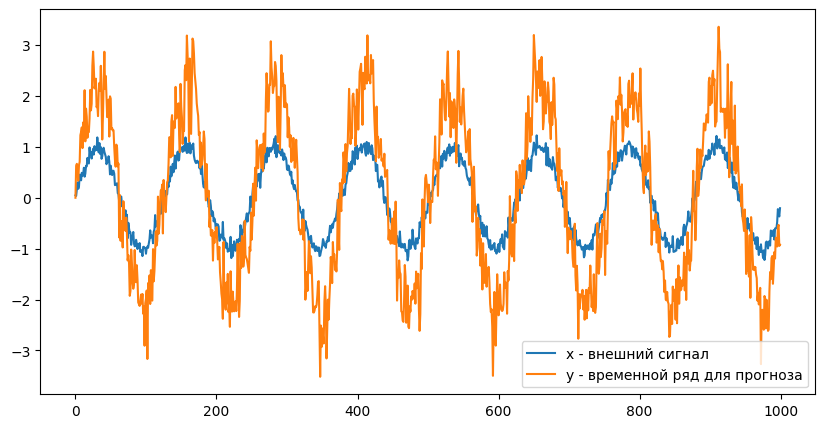

In [4]:
np.random.seed(42)
torch.manual_seed(42)

n = 1000
x = np.sin(np.linspace(0, 50, n)) + np.random.normal(0, 0.1, n)
y = np.zeros(n)

for t in range(1, n):
    y[t] = 0.4 * y[t-1] + 1.3 * x[t-1] + np.random.normal(0, 0.4)

plt.figure(figsize=(10, 5))
plt.plot(x, label='x - внешний сигнал')
plt.plot(y, label='y - временной ряд для прогноза')
plt.legend()
plt.show()



In [5]:

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

# Преобразуем в тензоры
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перенос данных на устройство
x = x.to(device)
y = y.to(device)

# Разделение данных на обучающую и тестовую выборки
train_size = int(n * 0.8)  # 80% на обучение
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Инициализация модели

In [6]:
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, y_prev):
        combined = torch.cat((x, y_prev), dim=0)  # Объединение по оси 0
        combined = combined.unsqueeze(0)  # Добавляем batch dimension
        out = self.relu(self.fc1(combined))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
input_size = 2  # x и y(t-1)
hidden_size = 100
output_size = 1

model = NARX(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучение модели

In [8]:
losses = []
num_epochs = 50

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = 0
    y_pred_train = torch.zeros_like(y_train, device=device)
    for t in range(1, train_size):
        y_prev = y_train[t-1].to(device)
        x_t = x_train[t].to(device)
        y_pred = model(x_t, y_prev)
        loss = loss + criterion(y_pred, y_train[t].unsqueeze(0).to(device))
        y_pred_train[t] = y_pred
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 639.216064453125
Epoch 10, Loss: 61.854774475097656
Epoch 20, Loss: 67.14408874511719
Epoch 30, Loss: 59.506439208984375
Epoch 40, Loss: 57.91413879394531


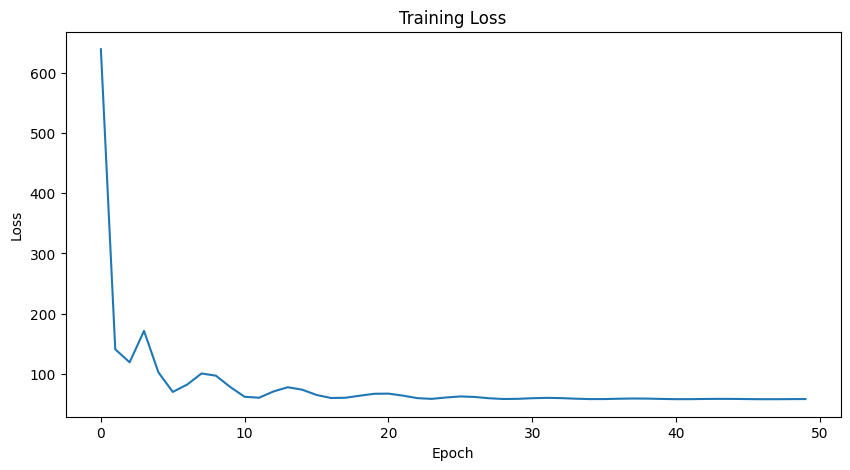

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Тестирование модели

In [10]:
y_test_pred = torch.zeros_like(y_test, device=device)
for t in range(1, n - train_size):
    y_prev = y_test[t-1].to(device)
    x_t = x_test[t].to(device)
    y_test_pred[t] = model(x_t, y_prev)

# Перенос данных обратно на CPU для визуализации
y_test_pred = y_test_pred.cpu()
y_train = y_train.cpu()
y_test = y_test.cpu()
y_pred_train = y_pred_train.cpu()
x = x.cpu()


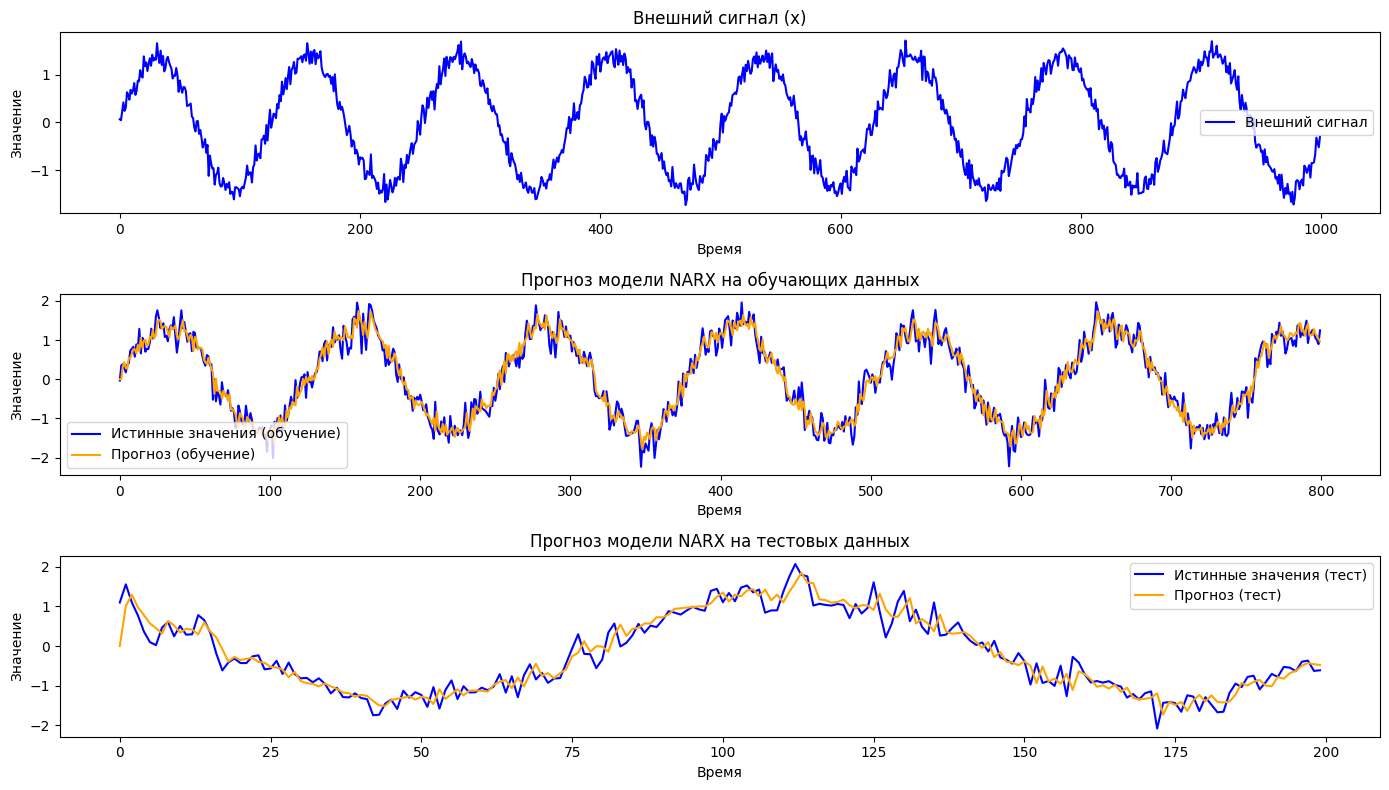

In [11]:
plt.figure(figsize=(14, 8))

# График внешнего сигнала x
plt.subplot(3, 1, 1)
plt.plot(x.detach().numpy(), label='Внешний сигнал', color='blue')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Внешний сигнал (x)')
plt.legend()

# График обучающей выборки
plt.subplot(3, 1, 2)
plt.plot(y_train.detach().numpy(), label='Истинные значения (обучение)', color='blue')
plt.plot(range(train_size), y_pred_train.detach().numpy(), label='Прогноз (обучение)', color='orange')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Прогноз модели NARX на обучающих данных')
plt.legend()

# График тестовой выборки
plt.subplot(3, 1, 3)
plt.plot(y_test.detach().numpy(), label='Истинные значения (тест)', color='blue')
plt.plot(range(n - train_size), y_test_pred.detach().numpy(), label='Прогноз (тест)', color='orange')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Прогноз модели NARX на тестовых данных')
plt.legend()

plt.tight_layout()
plt.show()
